# 07. PyTorch Experiment Tracking

## What we're going to cover

We're going to be running several different modelling experiments with various levels of data, model size and training time to try and improve on FoodVision Mini.

And due to its tight integration with PyTorch and widespread use, this notebook focuses on using TensorBoard to track our experiments.

However, the principles we're going to cover are similar across all of the other tools for experiment tracking.

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Getting setup** | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again. |
| **1. Get data** | Let's get the pizza, steak and sushi image classification dataset we've been using to try and improve our FoodVision Mini model's results. |
| **2. Create Datasets and DataLoaders** | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders. |
| **3. Get and customise a pretrained model** | Just like the last section, 06. PyTorch Transfer Learning we'll download a pretrained model from `torchvision.models` and customise it to our own problem. | 
| **4. Train model amd track results** | Let's see what it's like to train and track the training results of a single model using TensorBoard. |
| **5. View our model's results in TensorBoard** | Previously we visualized our model's loss curves with a helper function, now let's see what they look like in TensorBoard. |
| **6. Creating a helper function to track experiments** | If we're going to be adhering to the machine learner practitioner's motto of *experiment, experiment, experiment!*, we best create a function that will help us save our modelling experiment results. |
| **7. Setting up a series of modelling experiments** | Instead of running experiments one by one, how about we write some code to run several experiments at once, with different models, different amounts of data and different training times. | 
| **8. View modelling experiments in TensorBoard** | By this stage we'll have run eight modelling experiments in one go, a fair bit to keep track of, let's see what their results look like in TensorBoard. | 
| **9. Load in the best model and make predictions with it** | The point of experiment tracking is to figure out which model performs the best, let's load in the best performing model and make some predictions with it to *visualize, visualize, visualize!*. |

In [1]:
try:
    import torch
    import torchvision

    major = int(torch.__version__.split(".")[0])
    minor = int(torch.__version__.split(".")[1])
    assert (major >= 2) or (minor >= 12), "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import colorama

from colorama import Fore, Style, init
from torch import nn
from torchvision import transforms

init(autoreset=True)
# Try to get torchinfo, install it if it doesn't work

info_string = Style.BRIGHT + Fore.RED + "[INFO]: "
try:
    from torchinfo import summary
except:
    print(info_string + "Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    print(info_string + "going_modular scripts found...skipping download")
except:
    # Get the going_modular scripts
    print(info_string + "Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO]: going_modular scripts found...skipping download


In [3]:
# Setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Create a function to set seeds
def set_seeds(seed: int=42):
    """Sets random seeds for torch operations.
    
    Args:
    seed (int, optional): Random seed to set. Defaults to 42
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)

    # Set the seed for CUDA torch operations
    torch.cuda.manual_seed(42)

In [5]:
set_seeds()

## 1. Get data

As always, before we can run machine learning experiments, we'll need a dataset.

We're going to continue trying to improve upon the results we've been getting on FoodVision Mini.

In the previous section, [06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/), we saw how powerful using a pretrained model and transfer learning could be when classifying images of pizza, steak and sushi.

So how about we run some experiments and try to further improve our results?

To do so, we'll use similar code to the previous section to download the [`pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) (if the data doesn't already exist) except this time its been functionised.

This will allow us to use it again later. 

In [6]:
import os
import zipfile

from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    
    # This is where we want to unzip our files to
    image_path = data_path / destination

    # If the image folder doesn't exist, create it
    if image_path.is_dir():
        print(f"[INFO]: {image_path} directory already exists, skipping download")
    else:
        print(f"[INFO]: Did not find {image_path} directory, creating it...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the target data
        target_file = Path(source).name
        target_path = data_path / target_file
        with open(target_path, "wb") as f:
            request = requests.get(source)
            print(f"[INFO]: Downloading {target_file} from {source}...")
            f.write(request.content)

        with zipfile.ZipFile(target_path, "r") as zip_ref:
            print(f"[INFO]: Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file if needed
        if remove_source:
            os.remove(target_path)

    return image_path

In [7]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination="pizza_steak_sushi")
image_path

[INFO]: data/pizza_steak_sushi directory already exists, skipping download


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

Now we've got some data, let's turn it into PyTorch DataLoaders.

We can do so using the `create_dataloaders()` function we created in [05. PyTorch Going Modular part 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

And since we'll be using transfer learning and specifically pretrained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), we'll create a transform to prepare our images correctly.

To transform our images in tensors, we can use:
1. Manually created transforms using `torchvision.transforms`.
2. Automatically created transforms using `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms()`.
    * Where `MODEL_NAME` is a specific `torchvision.models` architecture, `MODEL_WEIGHTS` is a specific set of pretrained weights and `DEFAULT` means the "best available weights".
    
We saw an example of each of these in [06. PyTorch Transfer Learning section 2](https://www.learnpytorch.io/06_pytorch_transfer_learning/#2-create-datasets-and-dataloaders).

Let's see first an example of manually creating a `torchvision.transforms` pipeline (creating a transforms pipeline this way gives the most customization but can potentially result in performance degradation if the transforms don't match the pretrained model).

The main manual transformation we need to be sure of is that all of our images are normalized in ImageNet format (this is because pretrained `torchvision.models` are all pretrained on [ImageNet](https://www.image-net.org/)).

We can do this with:

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

## 2. Create Datasets and DataLoaders

Now we've got some data, let's turn it into PyTorch DataLoaders.

We can do so using the `create_dataloaders()` function we created in [05. PyTorch Going Modular part 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

And since we'll be using transfer learning and specifically pretrained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), we'll create a transform to prepare our images correctly.

To transform our images in tensors, we can use:
1. Manually created transforms using `torchvision.transforms`.
2. Automatically created transforms using `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms()`.
    * Where `MODEL_NAME` is a specific `torchvision.models` architecture, `MODEL_WEIGHTS` is a specific set of pretrained weights and `DEFAULT` means the "best available weights".
    
We saw an example of each of these in [06. PyTorch Transfer Learning section 2](https://www.learnpytorch.io/06_pytorch_transfer_learning/#2-create-datasets-and-dataloaders).

Let's see first an example of manually creating a `torchvision.transforms` pipeline (creating a transforms pipeline this way gives the most customization but can potentially result in performance degradation if the transforms don't match the pretrained model).

The main manual transformation we need to be sure of is that all of our images are normalized in ImageNet format (this is because pretrained `torchvision.models` are all pretrained on [ImageNet](https://www.image-net.org/)).

We can do this with:

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

In [8]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7f572c114220>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

Data transformed and DataLoaders created!

Let's now see what the same transformation pipeline looks like but this time by using automatic transforms.

We can do this by first instantiating a set of pretrained weights (for example `weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT`)  we'd like to use and calling the `transforms()` method on it.

In [9]:
# Setup train and test data paths
train_dir = image_path / "train"
test_dir = image_path / "test"


# Create requisite transforms automatically by getting EfficientNet_B1 Default weights
auto_transform = torchvision.models.EfficientNet_B1_Weights.DEFAULT.transforms()

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transform,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f560654e560>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [10]:
# Get the weights and set weights to default
model = torchvision.models.efficientnet_b1(weights='DEFAULT').to(device)

In [11]:
# Freeze the base layers
for param in model.features.parameters():
    param.requires_grad = False


In [12]:
# Change the classifier head to have out_features that match dimensionality of our data domain

# print(f"Before: {model.classifier} ")
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [13]:
from torchinfo import summary

# Print out a summary
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train a single model and track results

In [14]:
# Define a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

### Adjust `train()` function to track results with `SummaryWriter()`

We can use PyTorch's [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html) class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter. 

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the `SummaryWriter()` are saved in [TensorBoard format](https://www.tensorflow.org/tensorboard/).

In [15]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter

writer= SummaryWriter()

Now to use the writer, we could write a new training loop or we could adjust the existing `train()` function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

Let's take the latter option.

We'll get the `train()` function from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) and adjust it to use `writer`.

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with [`writer.add_scalars(main_tag, tag_scalar_dict)`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalars), where:
* `main_tag` (string) - the name for the scalars being tracked (e.g. "Accuracy")
* `tag_scalar_dict` (dict) - a dictionary of the values being tracked (e.g. `{"train_loss": 0.3454}`)
    * > **Note:** The method is called `add_scalars()` because our loss and accuracy values are generally scalars (single values).

Once we've finished tracking values, we'll call `writer.close()` to tell the `writer` to stop looking for values to track.

To start modifying `train()` we'll also import `train_step()` and `test_step()` from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py).

> **Note:** You can track information about your model almost anywhere in your code. But quite often experiments will be tracked *while* a model is training (inside a training/testing loop).
>
> The `torch.utils.tensorboard.SummaryWriter()` class also has many different methods to track different things about your model/data, such as [`add_graph()`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph) which tracks the computation graph of your model. For more options, [check the `SummaryWriter()` documentation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter).

In [16]:
from typing import Tuple, Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [17]:
# Train model
# Note: I'm not using engine.train(), as I updated the train() function above
set_seeds()
results=train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=5,
              device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0898 | train_acc: 0.5000 | test_loss: 1.0003 | test_acc: 0.6714
Epoch: 2 | train_loss: 0.9297 | train_acc: 0.7500 | test_loss: 0.9298 | test_acc: 0.7756
Epoch: 3 | train_loss: 0.8584 | train_acc: 0.8086 | test_loss: 0.8547 | test_acc: 0.8059
Epoch: 4 | train_loss: 0.7678 | train_acc: 0.9023 | test_loss: 0.7997 | test_acc: 0.8153
Epoch: 5 | train_loss: 0.8540 | train_acc: 0.7891 | test_loss: 0.7705 | test_acc: 0.7538


## 5. View our model's results in TensorBoard

The `SummaryWriter()` class stores our model's results in a directory called `runs/` in TensorBoard format by default.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

You know what that means?

It's time to follow the data visualizer's motto and *visualize, visualize, visualize!* 

You can view TensorBoard in a number of ways:

| Code environment | How to view TensorBoard | Resource |
| ----- | ----- | ----- |
| VS Code (notebooks or Python scripts) | Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard". | [VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration) |
| Jupyter and Colab Notebooks | Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`. | [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started) |

You can also upload your experiments to [tensorboard.dev](https://tensorboard.dev/) to share them publicly with others.

Running the following code in a Google Colab or Jupyter Notebook will start an interactive TensorBoard session to view TensorBoard files in the `runs/` directory.

```python
%load_ext tensorboard # line magic to load TensorBoard
%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory
```

In [18]:
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 44892), started 1:16:44 ago. (Use '!kill 44892' to kill it.)

## 6. Create a helper function to build `SummaryWriter()` instances

The `SummaryWriter()` class logs various information to a directory specified by the `log_dir` parameter.

How about we make a helper function to create a custom directory per experiment?

In essence, each experiment gets its own logs directory.

For example, say we'd like to track things like:
* **Experiment date/timestamp** - when did the experiment take place?
* **Experiment name** - is there something we'd like to call the experiment?
* **Model name** - what model was used?
* **Extra** - should anything else be tracked?

You could track almost anything here and be as creative as you want but these should be enough to start.

Let's create a helper function called `create_writer()` that produces a `SummaryWriter()` instance tracking to a custom `log_dir`.

Ideally, we'd like the `log_dir` to be something like: 

`runs/YYYY-MM-DD/experiment_name/model_name/extra` 

Where `YYYY-MM-DD` is the date the experiment was run (you could add the time if you wanted to as well).

In [19]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date in reverse order
    timestamp = datetime.now().strftime('%Y-%m-%d')

    if extra:
        log_dir= os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir= os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [20]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Step the scheduler to adjust the learning rate
        scheduler.step()
        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modeling experiments

### 7.1 What kind of experiments should you run?

That's the million dollar question in machine learning.

Because there's really no limit to the experiments you can run.

Such a freedom is why machine learning is so exciting and terrifying at the same time.

This is where you'll have to put on your scientist coat and remember the machine learning practitioner's motto: *experiment, experiment, experiment!*

Every hyperparameter stands as a starting point for a different experiment: 
* Change the number of **epochs**.
* Change the number of **layers/hidden units**.
* Change the amount of **data**.
* Change the **learning rate**.
* Try different kinds of **data augmentation**.
* Choose a different **model architecture**. 

With practice and running many different experiments, you'll start to build an intuition of what *might* help your model.

I say *might* on purpose because there's no guarantees.

But generally, in light of [*The Bitter Lesson*](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) (I've mentioned this twice now because it's an important essay in the world of AI), generally the bigger your model (more learnable parameters) and the more data you have (more opportunities to learn), the better the performance.

However, when you're first approaching a machine learning problem: start small and if something works, scale it up.

Your first batch of experiments should take no longer than a few seconds to a few minutes to run.

The quicker you can experiment, the faster you can work out what *doesn't* work, in turn, the faster you can work out what *does* work.


### 7.3 Download different datasets

In [21]:
# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO]: data/pizza_steak_sushi directory already exists, skipping download
[INFO]: data/pizza_steak_sushi_20_percent directory already exists, skipping download


In [22]:
# Create the paths to the respective training set
# Each model will use the same test path
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### 7.4 Transform Datasets and create DataLoaders

Next we'll create a series of transforms to prepare our images for our model(s).

To keep things consistent, we'll manually create a transform (just like we did above) and use the same transform across all of the datasets.

The transform will: 
1. Resize all the images (we'll start with 224, 224 but this could be changed).
2. Turn them into tensors with values between 0 & 1. 
3. Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) have been pretrained on ImageNet).

In [23]:
# Override the get_state_dict method to skip has check
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [24]:
# Create the transforms for EfficientNet by first grabbing 
# the default weights and using the weights .transform() method
auto_transform = torchvision.models.EfficientNet_B1_Weights.DEFAULT.transforms()

# Do the same for EfficientNetV2M
auto_transform_v2_m = torchvision.models.EfficientNet_V2_M_Weights.DEFAULT.transforms()

In [25]:
torchvision.models.EfficientNet_B1_Weights.DEFAULT.transforms(), torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

(ImageClassification(
     crop_size=[240]
     resize_size=[255]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ),
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [26]:
# EfficientnetB0,B2 DataLoader 

BATCH_SIZE = 32

# Create dataloaders for each data set of EfficientNet
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                     test_dir=test_dir,
                                                                                     transform=auto_transform,
                                                                                     batch_size=BATCH_SIZE)

train_dataloader_20_percent, _, _ = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                             test_dir=test_dir,
                                                             transform=auto_transform,
                                                             batch_size=BATCH_SIZE)
# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [27]:
# Efficientnetb2_m DataLoader

# Create dataloaders for each data set of EfficientNet
train_dataloader_10_percent_v2, test_dataloader_v2, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                     test_dir=test_dir,
                                                                                     transform=auto_transform,
                                                                                     batch_size=BATCH_SIZE)

train_dataloader_20_percent_v2, _, _ = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                             test_dir=test_dir,
                                                             transform=auto_transform,
                                                             batch_size=BATCH_SIZE)
# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [28]:
import torchvision
from torch import nn

OUT_FEATURES=len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0(set_seed: bool=True):
    if set_seeds:
        set_seeds()

    # Create the base model
    model = torchvision.models.efficientnet_b0(weights='DEFAULT').to(device)

    #  Freeze the base layer
    for param in model.features.parameters():
        param.requires_grad = False


    # Change the classifier head so out_features matches ours
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)
    
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB0 feature extractor
def create_effnetb2(set_seed: bool=True):
    if set_seed:
        set_seeds()

    # Create the base model
    model = torchvision.models.efficientnet_b2(weights='DEFAULT').to(device)

    #  Freeze the base layer
    for param in model.features.parameters():
        param.requires_grad = False


    # Change the classifier head so out_features matches ours
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_effnetv2_m(set_seed: bool=True):
    if set_seed:
        set_seeds()

    # Create the base model
    model = torchvision.models.efficientnet_v2_m(weights='DEFAULT').to(device)

    #  Freeze the base layer
    for param in model.features.parameters():
        param.requires_grad = False


    # Change the classifier head so out_features matches ours
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetv2_m"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [29]:
torchvision.models.efficientnet_b2(weights='DEFAULT').classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [30]:
# Create an effnetb0
effnetb0 = create_effnetb0()

# Create an effnetb1
effnetb2 = create_effnetb2()

# Create an effnetv2_m
effnetv2_m = create_effnetv2_m()

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.
[INFO] Created new effnetv2_m model.


In [31]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment
models = ["effnetb0", "effnetb2"]
models_v2 = ["effnetv2_m"]

# Create a DataLoaders dictionary for base EfficientNet
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

# Create a DataLoaders dictionary for V2 EfficientNet
train_dataloaders_v2 = {"data_10_percent": train_dataloader_10_percent_v2,
                     "data_20_percent": train_dataloader_20_percent_v2}

In [34]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            try:
                assert model_name in ["effnetb0", "effnetb2"], "Invalid model name"
                
                if model_name == "effnetb0":
                    model = create_effnetb0()
                else:
                    model = create_effnetb2()
            
            except AssertionError as e:
                print(e)

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-23/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0306 | train_acc: 0.4609 | test_loss: 0.8317 | test_acc: 0.8561
Epoch: 2 | train_loss: 0.9119 | train_acc: 0.6328 | test_loss: 0.6750 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.7341 | train_acc: 0.8320 | test_loss: 0.6839 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.6970 | train_acc: 0.7695 | test_loss: 0.6697 | test_acc: 0.7339
Epoch: 5 | train_loss: 0.7128 | train_acc: 0.7695 | test_loss: 0.6469 | test_acc: 0.8570
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-23/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9896 | train_acc: 0.5234 | test_loss: 0.9239 | test_acc: 0.6922
Epoch: 2 | train_loss: 0.7971 | train_acc: 0.7578 | test_loss: 0.8254 | test_acc: 0.7661
Epoch: 3 | train_loss: 0.7759 | train_acc: 0.6797 | test_loss: 0.7633 | test_acc: 0.8267
Epoch: 4 | train_loss: 0.6437 | train_acc: 0.7812 | test_loss: 0.6282 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.5730 | train_acc: 0.9062 | test_loss: 0.6281 | test_acc: 0.8570
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-23/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0306 | train_acc: 0.4609 | test_loss: 0.8317 | test_acc: 0.8561
Epoch: 2 | train_loss: 0.9119 | train_acc: 0.6328 | test_loss: 0.6750 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.7341 | train_acc: 0.8320 | test_loss: 0.6839 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.6970 | train_acc: 0.7695 | test_loss: 0.6697 | test_acc: 0.7339
Epoch: 5 | train_loss: 0.7128 | train_acc: 0.7695 | test_loss: 0.6469 | test_acc: 0.8570
Epoch: 6 | train_loss: 0.6448 | train_acc: 0.7734 | test_loss: 0.6404 | test_acc: 0.8570
Epoch: 7 | train_loss: 0.5647 | train_acc: 0.9180 | test_loss: 0.6161 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.5716 | train_acc: 0.9023 | test_loss: 0.5753 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.5688 | train_acc: 0.8086 | test_loss: 0.5835 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.5496 | train_acc: 0.8867 | test_loss: 0.5640 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9896 | train_acc: 0.5234 | test_loss: 0.9239 | test_acc: 0.6922
Epoch: 2 | train_loss: 0.7971 | train_acc: 0.7578 | test_loss: 0.8254 | test_acc: 0.7661
Epoch: 3 | train_loss: 0.7759 | train_acc: 0.6797 | test_loss: 0.7633 | test_acc: 0.8267
Epoch: 4 | train_loss: 0.6437 | train_acc: 0.7812 | test_loss: 0.6282 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.5730 | train_acc: 0.9062 | test_loss: 0.6281 | test_acc: 0.8570
Epoch: 6 | train_loss: 0.5871 | train_acc: 0.8086 | test_loss: 0.6276 | test_acc: 0.8778
Epoch: 7 | train_loss: 0.6094 | train_acc: 0.7969 | test_loss: 0.6129 | test_acc: 0.8778
Epoch: 8 | train_loss: 0.5805 | train_acc: 0.7969 | test_loss: 0.6337 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.6082 | train_acc: 0.8047 | test_loss: 0.6165 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.5769 | train_acc: 0.8203 | test_loss: 0.5984 | test_acc: 0.9081
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9591 | train_acc: 0.6479 | test_loss: 0.6980 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.7003 | train_acc: 0.8146 | test_loss: 0.5493 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.5994 | train_acc: 0.8583 | test_loss: 0.5095 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5032 | train_acc: 0.8938 | test_loss: 0.4112 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.4681 | train_acc: 0.8271 | test_loss: 0.4198 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-23/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9803 | train_acc: 0.5563 | test_loss: 0.7779 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.6860 | train_acc: 0.8292 | test_loss: 0.6153 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.5965 | train_acc: 0.8417 | test_loss: 0.5112 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4681 | train_acc: 0.8750 | test_loss: 0.4678 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4231 | train_acc: 0.9042 | test_loss: 0.4011 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-10-23/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9591 | train_acc: 0.6479 | test_loss: 0.6980 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.7003 | train_acc: 0.8146 | test_loss: 0.5493 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.5994 | train_acc: 0.8583 | test_loss: 0.5095 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5032 | train_acc: 0.8938 | test_loss: 0.4112 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.4681 | train_acc: 0.8271 | test_loss: 0.4198 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.4333 | train_acc: 0.8688 | test_loss: 0.4406 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.4652 | train_acc: 0.8667 | test_loss: 0.3936 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3932 | train_acc: 0.9125 | test_loss: 0.4313 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.4206 | train_acc: 0.8729 | test_loss: 0.3966 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3954 | train_acc: 0.9042 | test_loss: 0.3978 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9803 | train_acc: 0.5563 | test_loss: 0.7779 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.6860 | train_acc: 0.8292 | test_loss: 0.6153 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.5965 | train_acc: 0.8417 | test_loss: 0.5112 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4681 | train_acc: 0.8750 | test_loss: 0.4678 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4231 | train_acc: 0.9042 | test_loss: 0.4011 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.4009 | train_acc: 0.9167 | test_loss: 0.4196 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.4427 | train_acc: 0.8708 | test_loss: 0.4002 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.4051 | train_acc: 0.9146 | test_loss: 0.4235 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3675 | train_acc: 0.9083 | test_loss: 0.4207 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.3586 | train_acc: 0.9229 | test_loss: 0.4025 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [ ]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders_v2.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models_v2:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            model = create_effnetv2_m()

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            
            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

## 8. View experiments in TensorBoard

Ho, ho!

Look at us go!

Training eight models in one go?

Now that's living up to the motto!

*Experiment, experiment, experiment!*

How about we check out the results in TensorBoard?

In [ ]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

## 9. Load in the best model and make predictions with it

Looking at the TensorBoard logs for our eight experiments, it seems experiment number eight achieved the best overall results (highest test accuracy, second lowest test loss).

This is the experiment that used:
* EffNetB2 (double the parameters of EffNetB0)
* 20% pizza, steak, sushi training data (double the original training data)
* 10 epochs (double the original training time)

In essence, our biggest model achieved the best results.

Though it wasn't as if these results were far better than the other models.

The same model on the same data achieved similar results in half the training time (experiment number 6).

This suggests that potentially the most influential parts of our experiments were the number of parameters and the amount of data.

Inspecting the results further it seems that generally a model with more parameters (EffNetB2) and more data (20% pizza, steak, sushi training data) performs better (lower test loss and higher test accuracy).

More experiments could be done to further test this but for now, let's import our best performing model from experiment eight (saved to: `models/07_effnetb2_data_20_percent_10_epochs.pth`, you can [download this model from the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/models/07_effnetb2_data_20_percent_10_epochs.pth)) and perform some qualitative evaluations.

In other words, let's *visualize, visualize, visualize!*

We can import the best saved model by creating a new instance of EffNetB2 using the `create_effnetb2()` function and then load in the saved `state_dict()` with `torch.load()`.

In [31]:
# Setup best model
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [34]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to 
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size}MB")

EfficientNetB2 feature extractor model size: 29MB


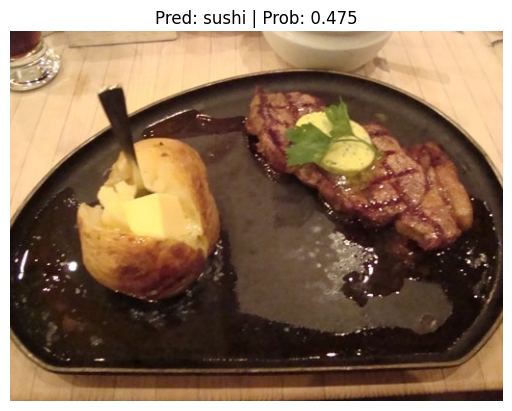

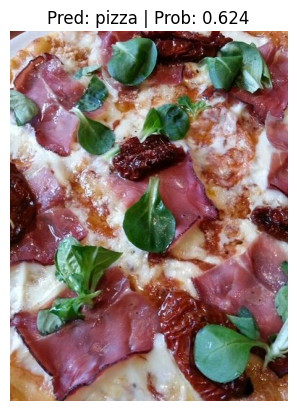

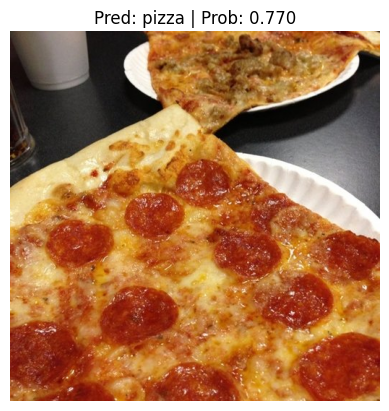

In [41]:
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot =3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))

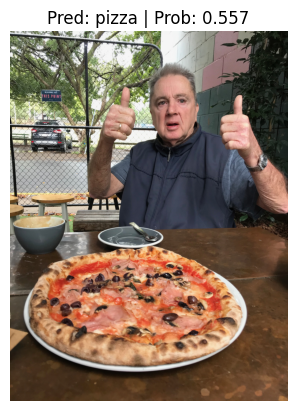

In [42]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)